# ATML Project Report

### Group 2
Members: Léonard Barras & Nathan Gyger

Github: https://github.com/svapili/FS2019_ATML_Group2 

# Melanoma image classification
### Goal:
Implement a deep learning algorithm to classify mole pictures as benign or malignant using the [ISIC database](https://isic-archive.com/).

### Approach description:

- Class imbalance => data augmentation
- Images => CNN as a logical choice
- Transfer learning

### Procedure

- Augment the data for better balancing of classes (50-50 /33-67 ?)
- Train different CNN on a few epochs with different optimizer, learning rate and batch sizes.
- Select the more performant regarding different metrics: Accuracy, TP, TN ... Be sure that the problem of class unbalance has been corrected
- ? Fine tune ?
- ? Modify the argmax threshold in the output, Plot ROC Curve for different models ?
- Modify data augmentation for getting a better specificity

# Results
TODO: add accuracy table for different parameters

## Learning curve
TODO: add graphic

# Example of use

In [17]:
import torch
print("Hello from cluster!")
print("Available GPU: ", torch.cuda.get_device_name(0))    

Hello from cluster!
Available GPU:  GeForce GTX 1080 Ti


### Imports and configuration

In [18]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import util
import csv
import glob
from copy import deepcopy

In [19]:
# Custom functions
import dataSplitter
import loader
import dataAugmenter
import SimpleNet
import train
import test_
import optimize

In [20]:
# Paths definitions
cluster = False
if cluster:
    Path = '/var/tmp/'
else:
    Path = '../data/'
dataDir = Path + 'ISIC-images'
trainDir = Path + 'ISIC-images/train/'
testDir = Path + 'ISIC-images/test/'
valDir = Path + 'ISIC-images/val/'


# Paths definitions for saving results and model state
my_path = os.getcwd()
dir = os.path.dirname(my_path)
results_dir = dir + '/results'
modelstate_dir = '/var/tmp/modelstate'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
if not os.path.exists(modelstate_dir):
    os.makedirs(modelstate_dir)

In [21]:
# Data pre-processing
# Data have first to be downloaded with data_downloader.py and extracted with data_extractor.py
newDataSplit = True # Set to true to split the data randomly again
dataPreprocessing = True # Set to true to resize and augment the data

In [22]:
# Check if we can use CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data pre-processing

In [23]:
# Performs a new random split of the data
if (newDataSplit):
    testRatio = .1
    valRatio = .1
    dataSplitter.split(trainDir, testDir, valDir, testRatio, valRatio)

Initializing directories...

Initial repartition:

../data/ISIC-images/train/
Benign images: 17428
Malignant images: 2227

../data/ISIC-images/test/
Benign images: 0
Malignant images: 0

../data/ISIC-images/val/
Benign images: 0
Malignant images: 0

Creating test set...
Creating validation set...
Job done!

Image repartition: 

../data/ISIC-images/train/
Benign images: 14118
Malignant images: 1805

../data/ISIC-images/test/
Benign images: 1742
Malignant images: 222

../data/ISIC-images/val/
Benign images: 1568
Malignant images: 200



In [25]:
# Preprocessing the data (resizing and augmenting)
if (dataPreprocessing):
    #dataAugmenter.preprocessData([trainDir, testDir, valDir])
    dataAugmenter.preprocessData([trainDir, testDir, valDir], outSize=(300,300), keepAspectRatio=True)

Resizing images in ../data/ISIC-images/train/...
Done!
Resizing images in ../data/ISIC-images/test/...
Done!
Resizing images in ../data/ISIC-images/val/...
Done!


### Data loading

In [26]:
batch_size = 8

Size of the dataset objects:  {'train': 15923, 'test': 1964, 'val': 1768}
Images class names:  ['benign', 'malignant']
Sample images:


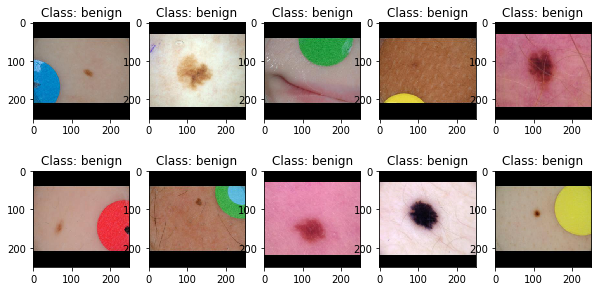

In [27]:
# Create dataset and dataloaders objects
image_datasets, dataloaders = loader.melanomaDataLoader(dataDir, batch_size=batch_size)

# Get dataset objects sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'val']}
print("Size of the dataset objects: ", dataset_sizes)

# Get the class names
class_names = image_datasets['train'].classes
print("Images class names: ", class_names)

# Visualize sample images
print("Sample images:")
loader.showSample(dataloaders, dataset_sizes, class_names)

### Network configuration

In [28]:
###############################
# SELECT MODEL
###############################
pretrained = False

#model = models.alexnet(pretrained=True)
#model = models.AlexNet(num_classes=2)
model = models.resnet18(pretrained=pretrained) 
#model = models.resnet50(pretrained=pretrained)
#model = models.densenet201()

###############################
# SELECT OPTIMIZER
###############################
finetune = True # Only has an effect if pretrained==True. If finetune==False, then fixed-feature

learning_rate = 0.001

optimizer_name="Adam" # "Adam" or "SGD"
        
optimizer = optimize.setup_optimizer(model, learning_rate, optimizer_name, pretrained, finetune)

###############################
# SELECT SCHEDULER
###############################
schedule = True
step_size = 10
gamma = 0.1

if schedule:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma)
else:
    scheduler = None
    
###############################
# SELECT EARLY STOPPING
###############################
earlyStop = True

if earlyStop:
    best_val_loss = np.inf
    best_model = None
    max_epochs = 5 # if no improvement after 5 epochs, stop training
    counter = 0

###############################
# SELECT LOSS FUNCTION
###############################
loss_fn = nn.CrossEntropyLoss()

n_epochs = 30
debug_training_status = False


saving = True

model = model.to(device)

### First Epoch Training Test

In [29]:
# test train and test function
if debug_training_status is True:
    train_loss, train_accuracy = train.train(model, dataloaders['train'], optimizer, loss_fn, device, status = debug_training_status)
    val_loss, val_accuracy, TP, TN, FP, FN  = test_.test(model, dataloaders['val'], loss_fn, device)
    test_loss, test_accuracy, TP, TN, FP, FN = test_.test(model, dataloaders['test'], loss_fn, device)
    print('Test training: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}, test_loss: {:.4f}, test_accuracy: {:.4f}'.format(
        train_loss,
        train_accuracy,
        val_loss,
        val_accuracy,
        test_loss,
        test_accuracy))


### Train and Save Result

In [31]:
    import time
    
    train_losses, train_accuracies = ['train_losses'], ['train_accuracies']
    val_losses, val_accuracies = ['val_losses'], ['val_accuracies']
    learn_rates = ['learning_rate']
    time_epoch = ['execution time']
    
    TPs = ['True Positives']
    TNs = ['True Negatives']
    FPs = ['False Positives']
    FNs = ['False Negatives']
    
    config  = model._get_name() + " " + "_bs=" + str(batch_size)
    
    ##############################
    # Training Epochs            #
    ##############################

    for epoch in range(n_epochs):
        start_time_epoch = time.time()
        
        train_loss, train_accuracy = train.train(model, dataloaders['train'], optimizer, loss_fn, device)
        val_loss, val_accuracy, TP, TN, FP, FN  = test_.test(model, dataloaders['val'], loss_fn, device) 
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        TPs.append(TP)
        TNs.append(TN)
        FPs.append(FP)
        FNs.append(FN)
        
        # SCHEDULER
        learn_rates.append(optimizer.param_groups[0]['lr'])
        if scheduler:
            scheduler.step()
        
        # TIME CALCULATION
        time_last_epoch = time.time() - start_time_epoch
        time_epoch.append(time_last_epoch)
        
        # OTHER METRICS
        
        
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}, learn_rates: {:}, epoch execution time: {:.4f}'.format(
            epoch + 1, n_epochs,
            train_losses[-1],
            train_accuracies[-1],
            val_losses[-1],
            val_accuracies[-1],
            learn_rates[-1],
            time_epoch[-1]))
        
        print('True Positive: {}, True Negative: {}, False Positives: {}, False Negative: {}'.format(
            TPs[-1],
            TNs[-1],
            FPs[-1],
            FNs[-1]))

    ##############################
    # Saving results             #
    ##############################

        if saving is True: #and (epoch+1) % 5 == 0:
            print('...saving...')
            name = config + '_' + loss_fn.__str__() + '_lr=' + str(learning_rate) + '_' +(optimizer.__str__()).split(' ')[0]

            #remove old results
            for filename in glob.glob(results_dir + '/' + name + '*'):
                os.remove(filename)
            for filename in glob.glob(modelstate_dir + '/' + name + '*'):
                os.remove(filename)

            name = name + '_Epoch_' + str(epoch+1)

            # save model weights
            torch.save(model.state_dict(), modelstate_dir + '/' + name + '.pth')

            # save results per epoch
            path = results_dir + '/' + name + '.csv'
            with open(path, 'a') as csvFile:
                writer = csv.writer(csvFile)
                writer.writerow(train_losses)
                writer.writerow(train_accuracies)
                writer.writerow(val_losses)
                writer.writerow(val_accuracies)
                writer.writerow(learn_rates)
                writer.writerow(time_epoch)
                writer.writerow(TPs)
                writer.writerow(TNs)
                writer.writerow(FPs)
                writer.writerow(FNs)
            csvFile.close()
            
    ##############################
    # Early stopping             #
    ##############################
        if earlyStop:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = deepcopy(model)
                counter = 0
            else:
                counter += 1
            if counter == max_epochs:
                print('No improvement for {} epochs; training stopped.'.format(max_epochs))
                
                print('...saving...')
                name = config + '_' + loss_fn.__str__() + '_lr=' + str(learning_rate) + '_' +(optimizer.__str__()).split(' ')[0]

                #remove old results
                for filename in glob.glob(results_dir + '/' + name + '*'):
                    os.remove(filename)
                for filename in glob.glob(modelstate_dir + '/' + name + '*'):
                    os.remove(filename)

                name = name + '_Epoch_' + str(epoch+1)

                # save model weights
                torch.save(best_model.state_dict(), modelstate_dir + '/' + name + '.pth')

                # save results per epoch
                path = results_dir + '/' + name + '.csv'
                with open(path, 'a') as csvFile:
                    writer = csv.writer(csvFile)
                    writer.writerow(train_losses)
                    writer.writerow(train_accuracies)
                    writer.writerow(val_losses)
                    writer.writerow(val_accuracies)
                    writer.writerow(learn_rates)
                    writer.writerow(time_epoch)
                    writer.writerow(TPs)
                    writer.writerow(TNs)
                    writer.writerow(FPs)
                    writer.writerow(FNs)
                csvFile.close()
                
                break


lenght of dataset : 15923
Epoch 1/30: train_loss: 0.2754, train_accuracy: 88.5888, val_loss: 0.2615, val_accuracy: 88.6878, learn_rates: 0.001, epoch execution time: 80.4665
True Positive: 0, True Negative: 1568, False Positives: 0, False Negative: 200
...saving...
lenght of dataset : 15923
Epoch 2/30: train_loss: 0.2661, train_accuracy: 88.6768, val_loss: 0.2526, val_accuracy: 88.1787, learn_rates: 0.001, epoch execution time: 80.9685
True Positive: 82, True Negative: 1477, False Positives: 91, False Negative: 118
...saving...
lenght of dataset : 15923
Epoch 3/30: train_loss: 0.2589, train_accuracy: 88.5386, val_loss: 0.2437, val_accuracy: 89.4231, learn_rates: 0.001, epoch execution time: 80.8072
True Positive: 46, True Negative: 1535, False Positives: 33, False Negative: 154
...saving...
lenght of dataset : 15923
Epoch 4/30: train_loss: 0.2522, train_accuracy: 88.6454, val_loss: 0.2406, val_accuracy: 89.2534, learn_rates: 0.001, epoch execution time: 80.8403
True Positive: 75, True 

### Compare models

In [34]:
files = glob.glob(results_dir + "/_*.csv", recursive=True)
files.sort()
print('Configuration \t'.expandtabs(60), 'Accuracy \t' , 'Specificity \t Sensitivity')
for f in files:
    file_name = f.rsplit('/')[-1]
    parameters = file_name.split('_')
    netname = parameters[1]
    batch_size = parameters[2]
    loss_fn = parameters[3]
    lr = parameters[4]
    optimizer = parameters[5]
    epochs_s = parameters[6]
    if lr == "lr=0.001" and batch_size=="bs=8":
        with open(f) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            list_training = []
            for row in csv_reader:
                list_training.append(row)
            train_losses = list_training[0]
            train_accuracies = list_training[1]
            val_losses = list_training[2]
            val_accuracies = list_training[3]

            time = list_training[4]

            TP = int(list_training[5][-1])
            TN = int(list_training[6][-1])
            FP = int(list_training[7][-1])
            FN = int(list_training[8][-1])

            specificity = TP/(TP+FN)
            sensitivity = TN/(TN+FP)

            epochs = list(range(1,len(val_accuracies)))

        print("------------------------------------------------------------------------------------------------------------")
        print(netname, batch_size, loss_fn, lr, optimizer, epochs_s, '\t|\t', val_accuracies[2][0:4], '\t|\t', str(specificity)[0:4], '\t|\t', str(sensitivity)[0:4])
        #print("%.2f" % (float(val_accuracies[-1])))

Configuration                                                Accuracy 	 Specificity 	 Sensitivity
------------------------------------------------------------------------------------------------------------
AlexNet  bs=32 CrossEntropyLoss() lr=0.001 SGD Epoch 	|	 67.3 	|	 0.0 	|	 1.0
------------------------------------------------------------------------------------------------------------
AlexNet  bs=8 CrossEntropyLoss() lr=0.001 SGD Epoch 	|	 67.3 	|	 0.0 	|	 1.0
------------------------------------------------------------------------------------------------------------
ResNet101  bs=8 CrossEntropyLoss() lr=0.001 Adam Epoch 	|	 81.3 	|	 0.68 	|	 0.85


IndexError: list index out of range

### Plot model training

In [ ]:
files_plot = []
files_plot.append(files[5])
files_plot.append(files[8])

curve_properties = ['xb-','xr-']

idx = 0
for f in files_plot:
    file_name = f.rsplit('/')[-1]
    parameters = file_name.split('_')
    netname = parameters[1]
    batch_size = parameters[2]
    loss_fn = parameters[3]
    lr = parameters[4]
    optimizer = parameters[5]
    epochs_s = parameters[6]
    if lr == "lr=0.001" and batch_size=="bs=8":
        with open(f) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            list_training = []
            for row in csv_reader:
                list_training.append(row)
            train_losses = list_training[0]
            train_accuracies = list_training[1]
            val_losses = list_training[2]
            val_accuracies = list_training[3]

            time = list_training[4]

            TP = int(list_training[5][-1])
            TN = int(list_training[6][-1])
            FP = int(list_training[7][-1])
            FN = int(list_training[8][-1])

            specificity = TP/(TP+FN)
            sensitivity = TN/(TN+FP)

            epochs = list(range(1,len(val_accuracies)))

        #val_losses = (list(np.float_(val_losses[1:])))
        val_accuracies = (list(np.float_(val_accuracies[1:])))
        print(val_losses)
        epochs = range(0,len(val_losses[1:]))
        #plt.plot(val_losses,'xb-',label = "Res-NET 50")
        plt.plot(val_accuracies,curve_properties[idx],label = netname+batch_size+' '+loss_fn+' '+lr+' '+optimizer)
        plt.legend(loc=4)
        plt.title('Training')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Val Losses', fontsize=16)
        idx=+1

### ROC curve analysis
#### Load model

In [1]:
models_to_load = glob.glob(modelstate_dir + "/_*.pth", recursive=True)
print
#print(name)
print(models_to_load)
files = glob.glob(model_to_load, recursive=True)
d_state_dict(torch.load(files[-1]))


NameError: name 'glob' is not defined

### Model 1

In [ ]:
#Model 1
# Define Model
model_roc = models.resnet50()
batch_size = 8
learning_rate = 0.001
optimizer = optimizer = torch.optim.Adam(model_roc.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

model_roc = model_roc.to(device)

model_roc.load_state_dict(torch.load(models_to_load[0]))

### Model 2

In [ ]:
#Model 2
# Define Model
model_roc = models.resnet50()
batch_size = 8
learning_rate = 0.001
optimizer = optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

model = model.to(device)

model_roc.load_state_dict(torch.load(models_to_load[1]))

### Test Loaded model

## Plot ROC Curves for model 

### Model 1

In [ ]:
    specificities1 = []
    sensitivities1 = []
    accuracies1 = []

    balances = np.arange(0.46,0.54,0.01)

    for balance in np.nditer(balances):
        print(type(float(balance)))
        val_loss, val_accuracy, TP, TN, FP, FN  = test_.test(model_roc, dataloaders['test'], loss_fn, device, balance=float(balance))
        specificities1.append(TP/(TP+FN))
        sensitivities1.append(TN/(TN+FP))
        accuracies1.append(val_accuracy)
    
    specificities1_np = np.asarray(specificities1)
    sensitivities1_np = np.asarray(sensitivities1)



### Model 2

In [ ]:
    specificities2 = []
    sensitivities2 = []
    accuracies2 = []

    balances = np.arange(0.46,0.54,0.01)

    for balance in np.nditer(balances):
        print(type(float(balance)))
        val_loss, val_accuracy, TP, TN, FP, FN  = test_.test(model_roc, dataloaders['test'], loss_fn, device, balance=float(balance))
        specificities1.append(TP/(TP+FN))
        sensitivities1.append(TN/(TN+FP))
        accuracies1.append(val_accuracy)
    
    specificities2_np = np.asarray(specificities2)
    sensitivities2_np = np.asarray(sensitivities2)

In [ ]:
    plt.plot(1-specificities1_np,sensitivities1_np,'xb-',label = "Res-NET 50")
    #plt.plot(1-specificities2_np,sensitivities2_np,'xr-',label = "other model")
    plt.legend(loc=4)
    plt.title('ROC')
    plt.ylim(0, 1.0)
    plt.xlabel('1-Specificity', fontsize=16)
    plt.ylim(0, 1.0)
    plt.ylabel('Sensitivity', fontsize=16)